# Evolution of Einstein's equations

# Initial data constants definition

# Initial data , setting length of the domain and discretization


In [179]:
m=2;
res=m;
N=2.0^m*1000.0;#2.0^m*100.0;
Xf=1.0;

dx=Xf/N;
dt=round(dx*0.4,digits=10);
Nt=100.0*2^m*10
Tf=Nt*dt; #final time

println("the final time is ", Tf)

the final time is 0.4


In [180]:
print(N)

4000.0

In [181]:
println("dx =", dx)
println("dt =", dt)
println("dx/dt =", dx/dt)
println("epsilon <= dx/dt * (1/2)^(2*2-1) = ", dx/dt*(1/2)^(2*2-1))

println("epsilon = dx/dt * (1/2)^(2*2) = ", dx/dt*(1/2)^(2*2))

println("epsilon = dx/dt * (1/2)^(2*3) = ", dx/dt*(1/2)^(2*3))

println("epsilon = dx/dt * (1/2)^(2) = ", dx/dt*(1/2)^(2))

dx =0.00025
dt =0.0001
dx/dt =2.5
epsilon <= dx/dt * (1/2)^(2*2-1) = 0.3125
epsilon = dx/dt * (1/2)^(2*2) = 0.15625
epsilon = dx/dt * (1/2)^(2*3) = 0.0390625
epsilon = dx/dt * (1/2)^(2) = 0.625


In [182]:
# Setting RESOLUTION

global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res$res"

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res2"

In [183]:
println(dx)
println(dt)

0.00025
0.0001


In [184]:
epsilon=0.1##0.01#0.05; #05; #02;#0.05; #0.05; #0.05;#0.05;#0.05; #dissipation strength (-1 for backwards integration)

0.1

# Grid

In [185]:
ori=0.0;
X1 = nothing
X1=range(ori, stop=Xf, step=dx);

println(size(X1))
println(X1)

(4001,)
0.0:0.00025:1.0


In [186]:
print(dx)
X = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)

L=length(X);
println("step size is  ", dx)

#T=range(dt,stop=Tf,step=dt)
T=range(0,stop=Tf-dt,step=dt)
println("the time step is ", dt)
println(size(T))
println(size(X))

println(X[L-3])
println(L)

0.00025step size is  0.00025
the time step is 0.0001
(4000,)
(4007,)
1.0
4007


In [187]:
radius=zeros(L)
print(L)
print(size(X1))
print(X1[1001])
for i in 1:L
    radius[i]=X[i]/(1-X[i])
end


4007(4001,)0.25

In [188]:
include("./ScalarField.jl");

In [189]:
using Interpolations

# Initial data of m β Ψ and Ψ,x

In [190]:
using PyCall   


scipy = pyimport("scipy")
scipyinterpolate = pyimport("scipy.interpolate")


####

initphi=zeros(L);
initphibar=zeros(L);

#PHI,X

r0=0.7
sigma=0.3
A=0.1449
initphibar[4:L-3] = init_gaussian_der(X1,r0,sigma,A)



#PHI FROM PSI,X
spl = scipyinterpolate.splrep(X[4:L-3], initphibar[4:L-3],k=5)
phi0=0
SFconstraint_phi_new(phi0,x) = scipyinterpolate.splev(x, spl)
initphi[4:L-3] = rungekutta4(SFconstraint_phi_new,phi0,X1)#,state_array[4:L-3,:])


#PHI
"initphi = init_gaussian(R,r0,sigma,A)"




"initphi = init_gaussian(R,r0,sigma,A)"

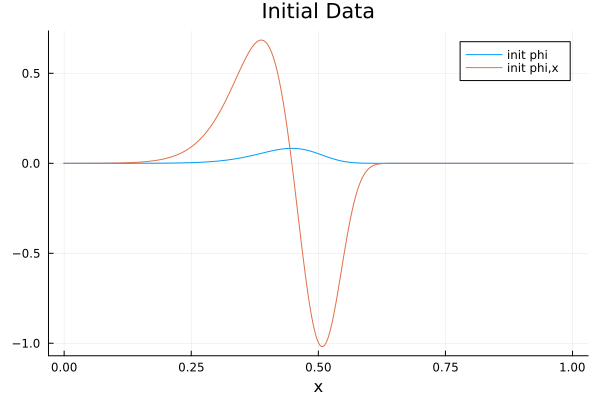

In [191]:
using Plots #showing initial data and the initial status of the horizon finder
plot(X, [initphi initphibar], xaxis="x",title="Initial Data", labels=["init phi" "init phi,x"])

In [ ]:
initm=zeros(L);
initbeta=zeros(L);
initpsi=zeros(L);
initpsibar=zeros(L);
state_array=[initm initbeta initpsi initpsibar];


#PSI
initpsi = initphi .* X ./ (1 .- X)
initpsi[L-3]=0
state_array[:,3]=initpsi;
state_array=ghost(state_array);


#PSI,X
initpsibar = initphibar .* X ./ (1 .- X) +  initphi ./ (1 .- X) .^2
initpsibar[L-3]=0
state_array[:,4]=initpsibar;
state_array=ghost(state_array);


#BETA
beta0=0
initbeta[4:L-3]=rk4wrapper(SFconstraint_beta,beta0,X1,state_array[4:L-3,:])
state_array[:,2]=initbeta;
state_array=ghost(state_array);


#M
m0=0
initm[4:L-3]=rk4wrapper(SFconstraint_m,m0,X1,state_array[4:L-3,:])
state_array[:,1]=initm;
state_array=ghost(state_array);


In [ ]:
using Plots #showing initial data and the initial status of the horizon finder
plot(X, [initpsi initpsibar], xaxis="x",title="Initial Data", labels=["init psi" "init psi,x"])

In [ ]:
using Plots #showing initial data and the initial status of the horizon finder
plot(X, state_array[:,2], xaxis="x",title="Initial Data", labels=["init beta"])

In [176]:
#monitor_ratio = 1-v/rexp(-2beta)
monitor_ratio = zeros(L)
for i in 1:L
    monitor_ratio = 2*state_array[:,1]/X[i]*(1-X[i])
    if monitor_ratio[i]>0.6
        print("hey BH")
    end
end

hey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey BHhey 

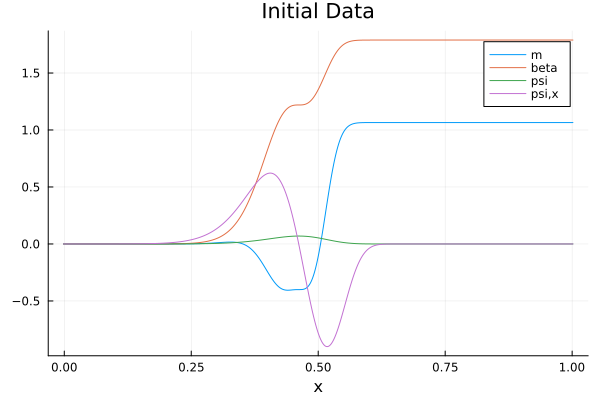

In [177]:
using Plots #showing initial data and the initial status of the horizon finder
plot(X, state_array, xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, xlim=[0.4, 1])

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [178]:
using CSV, Tables
CSV.write(dir*"/time_step0.csv", Tables.table(state_array), writeheader=false)

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/time_step0.csv"

 ## Time evolution

In [599]:
using Interpolations
using ProgressMeter
@showprogress for k in 1:length(T)

    #evolve psi,x
    state_array=rungekutta4molstep(SF_RHS,state_array,T,k,0) #evolve psi,x
    state_array=ghost(state_array)
    
    #calculate psi from psi,x
   " interp = cubic_spline_interpolation(X[4:L-3], state_array[4:L-3,4],  extrapolation_bc = Line())

    psi0=0
    SFconstraint_psi_new(psi0,X1) = interp.(X1)

    state_array[:,3] = rungekutta4(SFconstraint_psi_new,psi0,X)
    state_array=ghost(state_array)"
    
    #calculate psi form psi,x
    spl = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,4],k=5)
    psi0=0
    SFconstraint_psi_new(psi0,X) = scipyinterpolate.splev(X, spl)
    state_array[4:L-3,3] = rungekutta4(SFconstraint_psi_new,psi0,X1)
    state_array=ghost(state_array);
    
    #evolve m
    m0=0
    state_array[4:L-3,1]=rk4wrapper(SFconstraint_m,m0,X1,T)
    
    state_array=ghost(state_array)
    
    #evolve beta
    beta0=0
    state_array[4:L-3,2]=rungekutta4(SFconstraint_beta,beta0,X1)
    
    state_array=ghost(state_array)
    
    CSV.write(dir*"/time_step$k.csv", Tables.table(state_array), writeheader=false)
end

LoadError: InterruptException:

In [560]:
print(dir)

/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1

## Movie of the evolution

In [600]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 1100:1:1250#length(T)-1
    time_step=T[n+1]-T[n];
    IJulia.clear_output(true)
    functions3=DataFrame(CSV.File(dir*"/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
    d=round(T[n],digits=1)
    plot!(X1, [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"],ylim=[-1, 1], xlim=[0, 1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 1)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res3/time_step1100.csv" is not a valid file or doesn't exist

In [216]:
println(length(state_array[4:L-3,3]))

print(state_array[4:L-3,3])

2001


[0.0, 7.897982266498912e-14, 6.377307553777871e-13, 2.172419275496502e-12, 5.197489866847073e-12, 1.0246104186668724e-11, 1.787058891284146e-11, 2.864289242420148e-11, 4.3155050469193906e-11, 6.201966098064276e-11, 8.587036819695707e-11, 1.1536235625268521e-10, 1.5117285240395396e-10, 1.940016400569949e-10, 2.4457158177066786e-10, 3.0362915240663516e-10, 3.7194498260363154e-10, 4.503144127550981e-10, 5.395580576723268e-10, 6.405223821181683e-10, 7.540802873993189e-10, 8.81131709208202e-10, 1.0226042269085024e-9, 1.1794536844615047e-9, 1.352664823193527e-9, 1.543251926607914e-9, 1.7522594774482957e-9, 1.980762827223085e-9, 2.22986887840452e-9, 2.5007167795189235e-9, 2.7944786333482955e-9, 3.1123602184667938e-9, 3.4556017243392217e-9, 3.825478500212197e-9, 4.223301818032307e-9, 4.650419649629232e-9, 5.108217458405589e-9, 5.598119005778989e-9, 6.121587172625658e-9, 6.680124795978928e-9, 7.27527552123978e-9, 7.908624670160683e-9, 8.581800124868051e-9, 9.296473228192753e-9, 1.00543597005823

 2.313697893623384e-12, 1.9333090723806613e-12, 1.6134505340889534e-12, 1.3448249454101627e-12, 1.119508956080559e-12, 9.307586004266553e-13, 7.728409846907998e-13, 6.408888947892962e-13, 5.307753641808539e-13, 4.3900560126546173e-13, 3.626239947966108e-13, 2.991341983836293e-13, 2.464305451091577e-13, 2.0273926405320806e-13, 1.6656816523505979e-13, 1.3666363098905337e-13, 1.1197390263493109e-13, 9.161778378801126e-14, 7.485799784787093e-14, 6.107853896318055e-14, 4.976544475942689e-14, 4.049049682483812e-14, 3.289742270874318e-14, 2.6690232182859214e-14, 2.1623371806889074e-14, 1.7493426365294192e-14, 1.4132134336732388e-14, 1.1400517960980484e-14, 9.183957334669469e-15, 7.388062874956188e-15, 5.9352219492563044e-15, 4.761713928318868e-15, 3.815303773916408e-15, 3.053237867604281e-15, 2.440577426841636e-15, 1.948814804683548e-15, 1.554726461030503e-15, 1.2394236290976317e-15, 9.87567856174874e-16, 7.867238256431625e-16, 6.268263000750149e-16, 4.997417777796215e-16, 3.989086264891426e-

 1.0974315407861605e-16, 1.1045284563666317e-16, 1.1117098590373467e-16, 1.1189772665304653e-16, 1.126332233150007e-16, 1.1337763508800886e-16, 1.141311250533708e-16, 1.1489386029438132e-16, 1.1566601201984878e-16, 1.1644775569221646e-16, 1.1723927116048873e-16, 1.1804074279817323e-16, 1.1885235964646135e-16, 1.196743155628805e-16, 1.2050680937566402e-16, 1.2135004504409634e-16, 1.2220423182510573e-16, 1.2306958444638971e-16, 1.2394632328637483e-16, 1.2483467456132662e-16, 1.2573487051994444e-16, 1.2664714964579203e-16, 1.2757175686793486e-16, 1.2850894378017488e-16, 1.294589688692949e-16, 1.304220977527476e-16, 1.3139860342624826e-16, 1.3238876652175592e-16, 1.3339287557635525e-16, 1.3441122731258006e-16, 1.3544412693075095e-16, 1.364918884139315e-16, 1.3755483484614368e-16, 1.3863329874451953e-16, 1.3972762240610678e-16, 1.4083815827008789e-16, 1.4196526929621802e-16, 1.4310932936033505e-16, 1.442707236678478e-16, 1.4544984918616226e-16, 1.4664711509706618e-16, 1.4786294327015464e-16

2001


[0.0, 7.897982266498912e-14, 6.377307553777871e-13, 2.172419275496502e-12, 5.197489866847073e-12, 1.0246104186668724e-11, 1.787058891284146e-11, 2.864289242420148e-11, 4.3155050469193906e-11, 6.201966098064276e-11, 8.587036819695707e-11, 1.1536235625268521e-10, 1.5117285240395396e-10, 1.940016400569949e-10, 2.4457158177066786e-10, 3.0362915240663516e-10, 3.7194498260363154e-10, 4.503144127550981e-10, 5.395580576723268e-10, 6.405223821181683e-10, 7.540802873993189e-10, 8.81131709208202e-10, 1.0226042269085024e-9, 1.1794536844615047e-9, 1.352664823193527e-9, 1.543251926607914e-9, 1.7522594774482957e-9, 1.980762827223085e-9, 2.22986887840452e-9, 2.5007167795189235e-9, 2.7944786333482955e-9, 3.1123602184667938e-9, 3.4556017243392217e-9, 3.825478500212197e-9, 4.223301818032307e-9, 4.650419649629232e-9, 5.108217458405589e-9, 5.598119005778989e-9, 6.121587172625658e-9, 6.680124795978928e-9, 7.27527552123978e-9, 7.908624670160683e-9, 8.581800124868051e-9, 9.296473228192753e-9, 1.00543597005823

 2.313697893623384e-12, 1.9333090723806613e-12, 1.6134505340889534e-12, 1.3448249454101627e-12, 1.119508956080559e-12, 9.307586004266553e-13, 7.728409846907998e-13, 6.408888947892962e-13, 5.307753641808539e-13, 4.3900560126546173e-13, 3.626239947966108e-13, 2.991341983836293e-13, 2.464305451091577e-13, 2.0273926405320806e-13, 1.6656816523505979e-13, 1.3666363098905337e-13, 1.1197390263493109e-13, 9.161778378801126e-14, 7.485799784787093e-14, 6.107853896318055e-14, 4.976544475942689e-14, 4.049049682483812e-14, 3.289742270874318e-14, 2.6690232182859214e-14, 2.1623371806889074e-14, 1.7493426365294192e-14, 1.4132134336732388e-14, 1.1400517960980484e-14, 9.183957334669469e-15, 7.388062874956188e-15, 5.9352219492563044e-15, 4.761713928318868e-15, 3.815303773916408e-15, 3.053237867604281e-15, 2.440577426841636e-15, 1.948814804683548e-15, 1.554726461030503e-15, 1.2394236290976317e-15, 9.87567856174874e-16, 7.867238256431625e-16, 6.268263000750149e-16, 4.997417777796215e-16, 3.989086264891426e-

 1.0974315407861605e-16, 1.1045284563666317e-16, 1.1117098590373467e-16, 1.1189772665304653e-16, 1.126332233150007e-16, 1.1337763508800886e-16, 1.141311250533708e-16, 1.1489386029438132e-16, 1.1566601201984878e-16, 1.1644775569221646e-16, 1.1723927116048873e-16, 1.1804074279817323e-16, 1.1885235964646135e-16, 1.196743155628805e-16, 1.2050680937566402e-16, 1.2135004504409634e-16, 1.2220423182510573e-16, 1.2306958444638971e-16, 1.2394632328637483e-16, 1.2483467456132662e-16, 1.2573487051994444e-16, 1.2664714964579203e-16, 1.2757175686793486e-16, 1.2850894378017488e-16, 1.294589688692949e-16, 1.304220977527476e-16, 1.3139860342624826e-16, 1.3238876652175592e-16, 1.3339287557635525e-16, 1.3441122731258006e-16, 1.3544412693075095e-16, 1.364918884139315e-16, 1.3755483484614368e-16, 1.3863329874451953e-16, 1.3972762240610678e-16, 1.4083815827008789e-16, 1.4196526929621802e-16, 1.4310932936033505e-16, 1.442707236678478e-16, 1.4544984918616226e-16, 1.4664711509706618e-16, 1.4786294327015464e-16

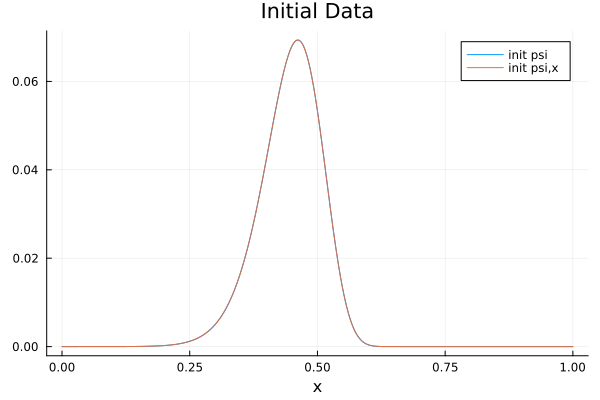

In [221]:
aa = SFconstraint_4(beta0,X1,state_array[4:L-3,:])
println(length(aa))

println(aa) # == state_array[4:L-3,3]

plot(X1, [aa, state_array[4:L-3,3]], xaxis="x",title="Initial Data", labels=["init psi" "init psi,x"])

In [222]:
print(aa-state_array[4:L-3,3])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [51]:
spl = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,2],k=5)
f(x) = scipyinterpolate.splev(x, spl)

f(0.5)
#z = 2.0 .* pi .* (1.0 .- x1) .* f[x1]

0-dimensional Array{Float64, 0}:
0.0005235987755982988

In [52]:
state_array[1004,2]

0.0005235987755982988

In [53]:
print(X[1004])

0.5

In [117]:
aux=state_array[4:L-3,:]
aux[:,2]=zeros(L-6)
bb = SFconstraint_4(beta0,X1,state_array[4:L-3,:])
println(length(bb))
println(bb)

2001


[-2.276993760953177e-25, 2.9851868644513903e-9, 1.2083245494367064e-8, 2.7511617194290325e-8, 4.949274323655073e-8, 7.825415905898219e-8, 1.1402859003703194e-7, 1.5705404885447227e-7, 2.0757393449709592e-7, 2.658371328941882e-7, 3.320981192328848e-7, 4.066170619708989e-7, 4.896599285734445e-7, 5.814985930005408e-7, 6.824109449712777e-7, 7.926810010319447e-7, 9.125990174553613e-7, 1.0424616049990654e-6, 1.1825718455504528e-6, 1.3332394106873177e-6, 1.49478068218267e-6, 1.6675188744830504e-6, 1.8517841591900452e-6, 2.0479137915750617e-6, 2.256252239157825e-6, 2.4771513123795438e-6, 2.7109702974020566e-6, 2.95807609106471e-6, 3.2188433380312113e-6, 3.4936545701590574e-6, 3.782900348124612e-6, 4.0869794053374805e-6, 4.406298794178007e-6, 4.741274034592517e-6, 5.092329265081132e-6, 5.4598973961136425e-6, 5.84442026600924e-6, 6.24634879931656e-6, 6.666143167730822e-6, 7.1042729535855364e-6, 7.561217315956552e-6, 8.037465159416833e-6, 8.533515305480938e-6, 9.049876666778504e-6, 9.587068423996

-1.7183150377926135, -1.7497247017025521, -1.780784907348551, -1.8114863891968038, -1.8418199701176452, -1.871776566437762, -1.9013471929900103, -1.9305229681573448, -1.9592951189071666, -1.9876549858125312, -2.0155940280564306, -2.0431038284154264, -2.070176098218827, -2.0968026822796317, -2.12297556379332, -2.148686869200603, -2.173928873010223, -2.1986940025778536, -2.2229748428371234, -2.2467641409787533, -2.270054811073809, -2.292839938637086, -2.3151127851265363, -2.336866792374754, -2.358095586948458, -2.378792984431978, -2.3989529936306857, -2.418569820690385, -2.4376378731286534, -2.4561517637741948, -2.474106314610204, -2.491496560517884, -2.5083177529161427, -2.524565363293743, -2.540235086629981, -2.5553228447002043, -2.569824789262436, -2.583737305121459, -2.5970570130667507, -2.6097807726807845, -2.621905685014174, -2.6334290951243573, -2.6443485944744185, -2.6546620231889393, -2.66436747216364, -2.6734632850258606, -2.6819480599428576, -2.6898206512751526, -2.69708017107

-1.5728435590508535e-13, -1.2358093602606944e-13, -9.691847414514227e-14, -7.586304026250518e-14, -5.926488315295376e-14, -4.6203736431019245e-14, -3.594432315178742e-14, -2.790022171863818e-14, -2.1604574537107002e-14, -1.6686386526216962e-14, -1.2851381680056633e-14, -9.866569506722216e-15, -7.547825416763077e-15, -5.749915117440216e-15, -4.3584971246458265e-15, -3.2837232843713747e-15, -2.4551277740284694e-15, -1.817553012465464e-15, -1.3279084099124617e-15, -9.525967453582672e-16, -6.654746798685773e-16, -4.462397588328856e-16, -2.7915727048923214e-16, -1.5205738052430943e-16, -5.554677185448475e-17, 1.760982125832023e-17, 7.297379520545633e-17, 1.14810942024505e-16, 1.4638634682979377e-16, 1.70193804909802e-16, 1.8813391728345837e-16, 2.0165204821861371e-16, 2.11844959073534e-16, 2.1954305044594672e-16, 2.253736522765477e-16, 2.2980962105350407e-16, 2.332065715223723e-16, 2.3583133655490296e-16, 2.3788367230674817e-16, 2.395127738410789e-16, 2.408298129114578e-16, 2.41917433769697

, 1.0087450407121207e-15, 1.0167509537336454e-15, 1.0248849613635148e-15, 1.0331501626648333e-15, 1.041549757483247e-15, 1.0500870505773714e-15, 1.0587654559540443e-15, 1.0675885014203278e-15, 1.0765598333650366e-15, 1.0856832217833843e-15, 1.0949625655593107e-15, 1.1044018980210286e-15, 1.114005392786429e-15, 1.1237773699161344e-15, 1.1337223023932685e-15, 1.1438448229503508e-15, 1.1541497312652194e-15, 1.1646420015494484e-15, 1.1753267905544896e-15, 1.1862094460225867e-15, 1.197295515611583e-15, 1.208590756324899e-15, 1.220101144480375e-15, 1.2318328862542244e-15, 1.243792428839217e-15, 1.25598647225921e-15, 1.2684219818855383e-15, 1.281106201704393e-15, 1.2940466683882761e-15, 1.3072512262289728e-15, 1.32072804299422e-15, 1.3344856267754095e-15, 1.3485328438993617e-15, 1.3628789379833976e-15, 1.3775335502197781e-15, 1.3925067409830369e-15, 1.407809012861971e-15, 1.4234513352271038e-15, 1.4394451704543754e-15, 1.455802501936811e-15, 1.4725358640280388e-15, 1.489658374074876e-15, 1.50

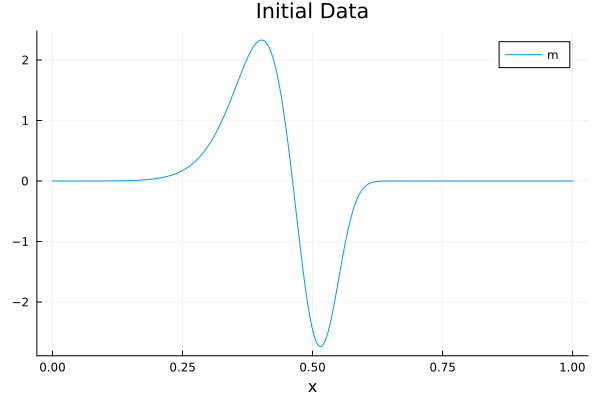

In [119]:
using Plots #showing initial data and the initial status of the horizon finder
plot(X1, bb, xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, xlim=[0.4, 1])

In [86]:
println(length(state_array[4:L-3,2]))
println(state_array[4:L-3,2])

2001


[0.0, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.000

 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.00052359

 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.00052359

, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235